In [414]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from scipy.integrate import odeint
from scipy.optimize import fmin_tnc, differential_evolution
from scipy.special import gamma
from scipy.signal import fftconvolve
import seaborn as sns # plotting boxplotz
import string

from functions import *
from scipy import signal
# from Fit_functions_with_irf import *
from scipy.optimize import Bounds

In [415]:
"""Recycle params for plotting"""
plt.rc('xtick', labelsize = 15)
plt.rc('xtick.major', pad = 3)
plt.rc('ytick', labelsize = 15)
plt.rc('lines', lw = 0.5, markersize = 20)
plt.rc('legend', fontsize = 10)

### PLQY Correction

This is the code that Aaron created to find corrected PLQY with saturated 1 Sun measurements and partial, unsaturated Sun measurements. This code assumes each sample is measured similarly (one blank per sample).

Below is used to sum the excitation/emission values underneath the curve and within set boundaries. This may be used for 1 Sun.

Emission cts = 1.381e+02, Excitation cts = 3.646e+04
Emission cts = 1.209e+02, Excitation cts = 5.805e+03
Emission cts = 1.701e+02, Excitation cts = 5.711e+03
Emission cts = 3.324e+02, Excitation cts = 5.901e+03
Emission cts = 2.838e+02, Excitation cts = 6.032e+03


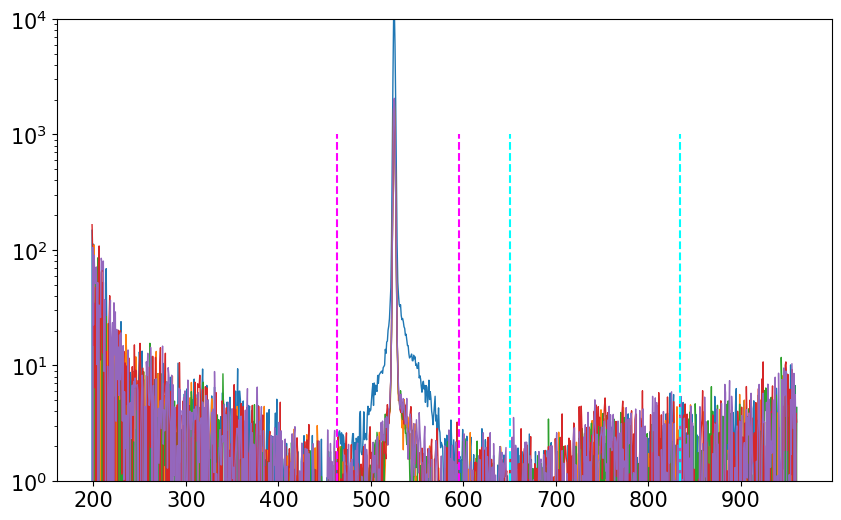

In [196]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 5 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

This is for partial, unsaturated Sun

Emission cts = 2.032e+01, Excitation cts = 3.088e+04
Emission cts = 6.173e+01, Excitation cts = 5.340e+03
Emission cts = 5.888e+01, Excitation cts = 4.855e+03
Emission cts = 1.203e+02, Excitation cts = 4.946e+03
Emission cts = 8.923e+01, Excitation cts = 4.934e+03
Emission cts = 9.525e+01, Excitation cts = 4.266e+03
Emission cts = 1.184e+02, Excitation cts = 5.183e+03


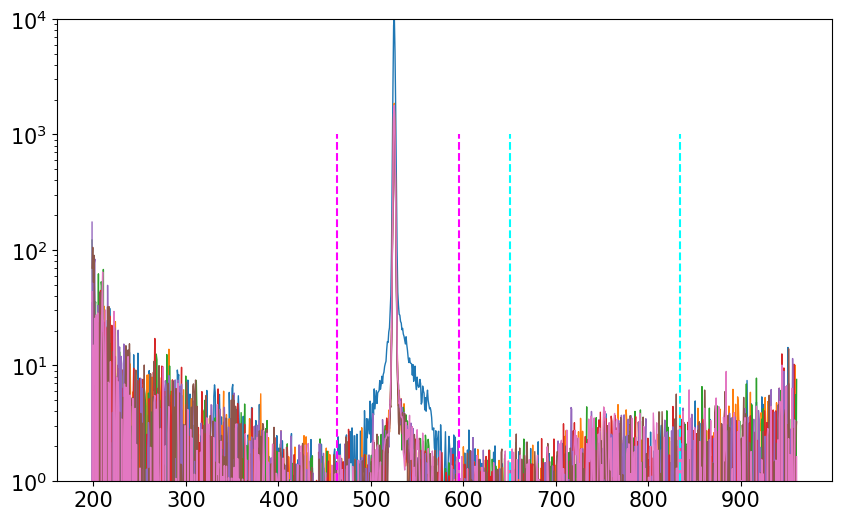

In [212]:
data_unsat = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Glass_Cs22_0.5Sun.txt', delimiter = '\t', index_col = False)
del data_unsat[data_unsat.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data_unsat.values[emhigh,0]*np.ones(100) #input dashed lines to show boundaries
emlinelow = data_unsat.values[emlow,0]*np.ones(100)

exlinehigh = data_unsat.values[exhigh,0]*np.ones(100)
exlinelow = data_unsat.values[exlow,0]*np.ones(100)

emcts_low = np.zeros(7) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_low = np.zeros(7)


linebounds = np.linspace(1,1000,100)

fig = plt.figure(figsize = (10,6))
for K in range(7):
    plt.plot(data_unsat.values[:,0],data_unsat.values[:,K+1],'-',lw=1)
    emcts_low[K] = np.sum(data_unsat.values[emlow:emhigh,K+1])
    excts_low[K] = np.sum(data_unsat.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data_unsat.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data_unsat.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [204]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

print(correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[:1],excts_low[0],1,0.5)) #this prints the PLQY for each of the measurements!!


[inf inf inf inf]


/var/folders/h1/ldsl23c13xz30r6vnfw4vq400000gn/T/ipykernel_97748/4044942692.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return 100*emdiff/(exdiff*ratio)


## 06/22/23: 1.4M Cs22Br15 w/ and w/o Me4Pacz in the precursor. 
### Both sets of solutions include Control, 1% Imn, and 1% ImnBr. PLQY was taken for films on glass, halfstacks, and devices. 

Cs22 on glass below - Emission and Excitation counts included for blank and each sample measurement at 1 Sun and 0.5 Sun

Emission cts = 1.381e+02, Excitation cts = 3.646e+04
Emission cts = 1.209e+02, Excitation cts = 5.805e+03
Emission cts = 1.701e+02, Excitation cts = 5.711e+03
Emission cts = 3.324e+02, Excitation cts = 5.901e+03
Emission cts = 2.838e+02, Excitation cts = 6.032e+03


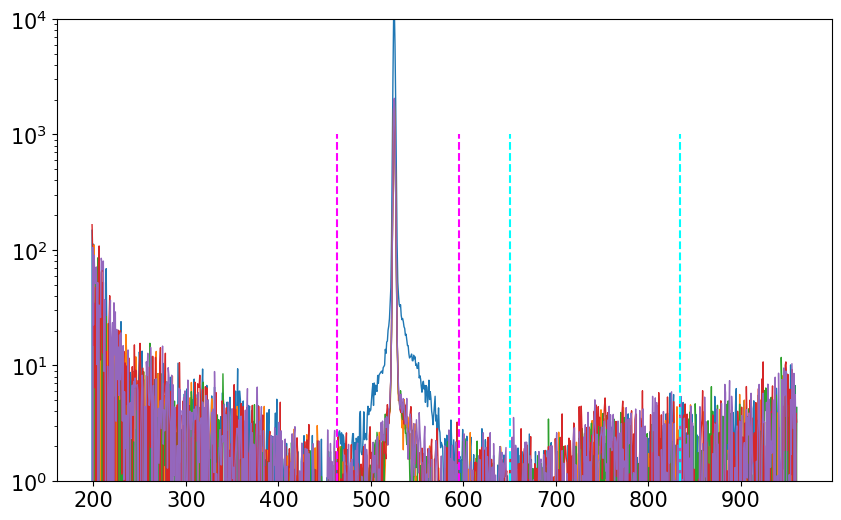

In [190]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


#average sample data collected (dont include blank!)            
#data['mean'] = (data.to_numpy()[:,2:].mean(axis=1))
#(data['mean'])

#concatenate Wavelength, Blank, and Average of Samples 
emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 5


emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(size)
excts_high = np.zeros(size)

#taking detector sensibility into account 

fig = plt.figure(figsize = (10,6))
for K in range(size):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1)
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1])
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

Emission cts = 2.032e+01, Excitation cts = 3.088e+04
Emission cts = 6.173e+01, Excitation cts = 5.340e+03
Emission cts = 5.888e+01, Excitation cts = 4.855e+03
Emission cts = 1.203e+02, Excitation cts = 4.946e+03
Emission cts = 8.923e+01, Excitation cts = 4.934e+03
Emission cts = 9.525e+01, Excitation cts = 4.266e+03
Emission cts = 1.184e+02, Excitation cts = 5.183e+03


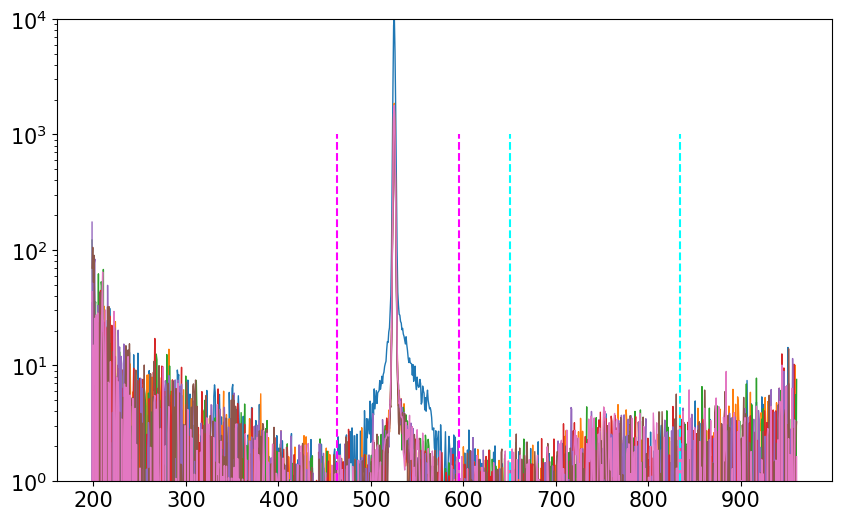

In [201]:
data_unsat = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Glass_Cs22_0.5Sun.txt', delimiter = '\t', index_col = False)
del data_unsat[data_unsat.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data_unsat.values[emhigh,0]*np.ones(100) #input dashed lines to show boundaries
emlinelow = data_unsat.values[emlow,0]*np.ones(100)

exlinehigh = data_unsat.values[exhigh,0]*np.ones(100)
exlinelow = data_unsat.values[exlow,0]*np.ones(100)

emcts_low = np.zeros(7) #creates matrix of 0s
excts_low = np.zeros(7)


linebounds = np.linspace(1,1000,100)

fig = plt.figure(figsize = (10,6))
for K in range(7):
    plt.plot(data_unsat.values[:,0],data_unsat.values[:,K+1],'-',lw=1)
    emcts_low[K] = np.sum(data_unsat.values[emlow:emhigh,K+1])
    excts_low[K] = np.sum(data_unsat.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data_unsat.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data_unsat.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [193]:
print(AaronPLQY(emcts_high[1:],emcts_high[0],excts_low[1],excts_low[0],1,0.5))

[-0.03367164  0.06270309  0.3802561   0.2853026 ]


## PLQY for 1.4M Cs22 = 0.3802561 %

Now, 1.4M Cs22 + 1% Imn 

Emission cts = 9.424e+01, Excitation cts = 3.434e+04
Emission cts = 4.046e+02, Excitation cts = 5.334e+03
Emission cts = 4.337e+02, Excitation cts = 5.289e+03
Emission cts = 1.415e+02, Excitation cts = 5.233e+03
Emission cts = 2.892e+02, Excitation cts = 5.199e+03


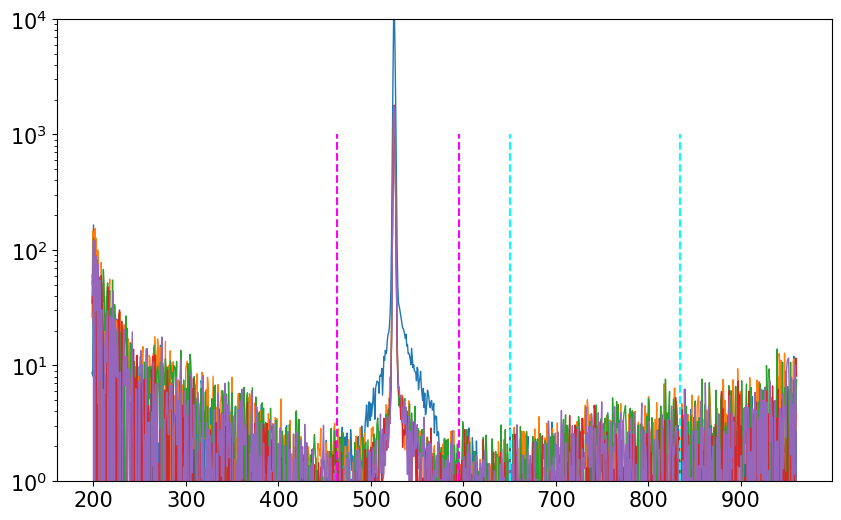

In [202]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()



In [199]:
def AaronPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

In [203]:
print(AaronPLQY(emcts_high[1:],emcts_high[0],excts_low[2],excts_low[0],1,0.5)) 

[0.59616987 0.65209809 0.09073313 0.37448651]


## PLQY for 1.4M Cs22+1%Imn = 0.65209809 

Now, PLQY for Cs22 +1% ImnBr

Emission cts = 1.806e+02, Excitation cts = 3.621e+04
Emission cts = 1.580e+02, Excitation cts = 6.071e+03
Emission cts = 1.984e+02, Excitation cts = 6.065e+03
Emission cts = 4.445e+02, Excitation cts = 6.248e+03
Emission cts = 3.161e+02, Excitation cts = 6.303e+03


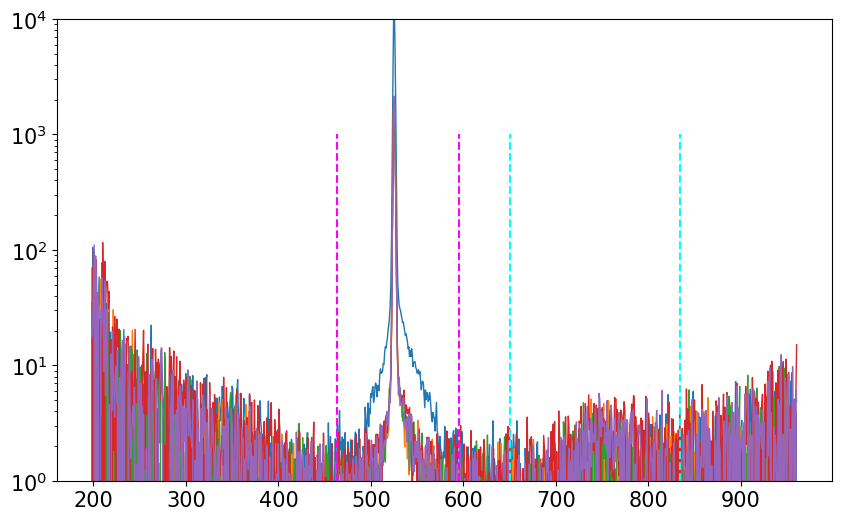

In [205]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()



In [206]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

print(correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[3],excts_low[0],1,0.5)) #this prints the PLQY for each of the measurements!!


[-0.04363271  0.03430523  0.50866101  0.26111297]


## PLQY for 1.4M Cs22+ 1%ImnBr = 0.50866101

Now, for 1.4M Cs22+ Me4 Control

Emission cts = 1.319e+02, Excitation cts = 3.718e+04
Emission cts = 2.062e+02, Excitation cts = 5.784e+03
Emission cts = 1.837e+02, Excitation cts = 5.787e+03
Emission cts = 2.012e+02, Excitation cts = 5.996e+03
Emission cts = 4.401e+02, Excitation cts = 6.198e+03


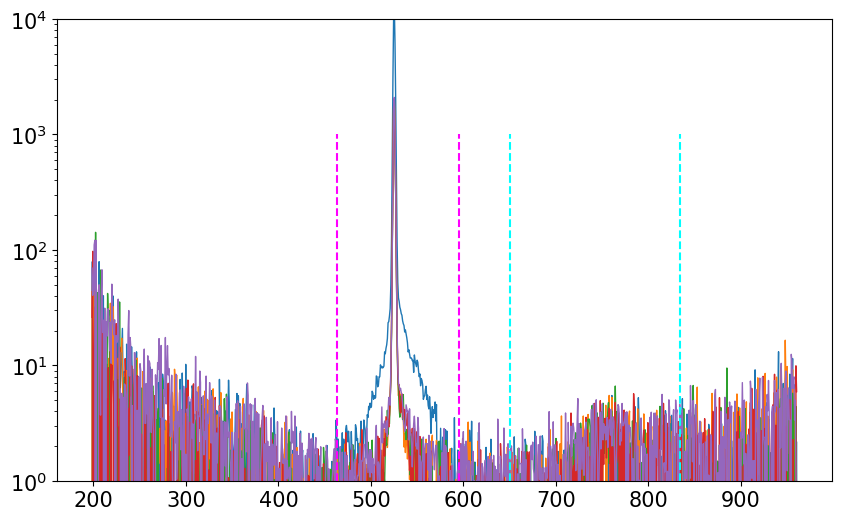

In [273]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22+Me4_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()


In [214]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

print(correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[4],excts_low[0],1,0.5)) #this prints the PLQY for each of the measurements!!


[0.14318309 0.09983465 0.13350214 0.59397724]


## PLQY for 1.4M Cs22 + Me4 = 0.59397724

Now, for Cs22+Me4+1%Imn

Emission cts = 5.251e+01, Excitation cts = 3.727e+04
Emission cts = 2.313e+02, Excitation cts = 4.767e+03
Emission cts = 2.412e+02, Excitation cts = 5.291e+03
Emission cts = 4.286e+02, Excitation cts = 5.372e+03
Emission cts = 2.983e+02, Excitation cts = 7.398e+03


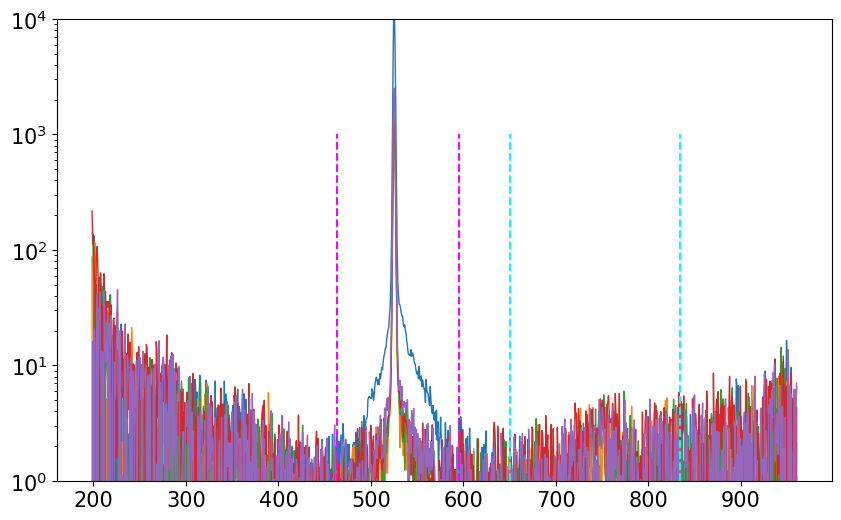

In [215]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22+Me4_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()


In [216]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

print(correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[5],excts_low[0],1,0.5)) #this prints the PLQY for each of the measurements!!


[0.3359138  0.35438999 0.70652841 0.46170009]


## PLQY for 1.4M Cs22 + Me4 + 1%Imn = 0.70652841

Now, for 1.4M Cs22 + Me4 + 1%ImnBr

Emission cts = 6.785e+01, Excitation cts = 3.283e+04
Emission cts = 3.616e+02, Excitation cts = 5.452e+03
Emission cts = 2.931e+02, Excitation cts = 5.421e+03
Emission cts = 3.401e+02, Excitation cts = 5.802e+03
Emission cts = 4.590e+02, Excitation cts = 5.748e+03


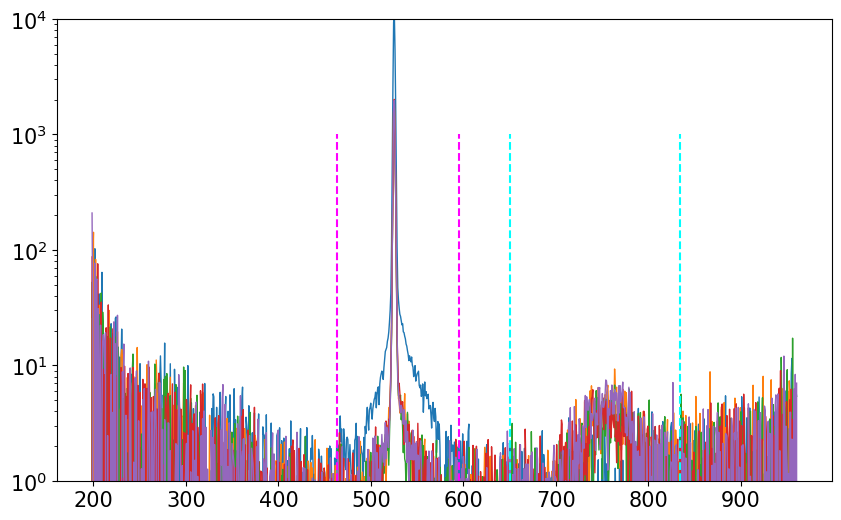

In [217]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Cs22+Me4_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [222]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

print(correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[6],excts_low[0],1,0.5)) #this prints the PLQY for each of the measurements!!


[0.57137718 0.43816305 0.52971476 0.76105724]


## PLQY for 1.4M Cs22 + Me4 + 1%ImnBr = 0.76105724

# Here are the PLQYs for 1.4M Cs22 on glass w and w/o Me4 in the precursor (and 1% Imn/ImnBr additive):

## 1.4M Cs22 = 0.3802561 %
## 1.4M Cs22+1%Imn = 0.65209809 %
## 1.4M Cs22+ 1%ImnBr = 0.50866101 %
## 1.4M Cs22 + Me4 = 0.59397724 %
## 1.4M Cs22 + Me4 + 1%Imn = 0.70652841 %
## 1.4M Cs22 + Me4 + 1%ImnBr = 0.76105724 %

Cs22 on halfstacks below - Emission and Excitation counts included for blank and each sample measurement at 1 Sun and 0.5 Sun. 
This is for partial sun, and will be called through all halfstack code.

      Wavelength           1           2          3          4          5  \
0     198.644331 -104.490535  -52.245268  95.782991  43.537723  26.122634   
1     199.407799   97.275058 -105.381312 -97.275058 -24.318764 -24.318764   
2     200.171236  142.243964   22.459573  29.946098 -44.919146  22.459573   
3     200.934641  131.248846   41.447004  96.709676 -27.631336   6.907834   
4     201.698014   12.814534  134.552607 -51.258136  25.629068  44.850869   
...          ...         ...         ...        ...        ...        ...   
1019  957.174282   -0.569297   -2.846486   4.554378   9.678052   4.554378   
1020  957.896475    0.562088    0.000000  -0.562088  -1.124177   4.496707   
1021  958.618618   -4.464230    1.116058   6.138317  -6.138317  -1.116058   
1022  959.340711   -4.964897   -4.413242   0.551655  -2.758276  -1.103310   
1023  960.062755    3.784889   -3.244190  -7.029079  -0.000000  -0.540698   

              8         14  
0     17.415089  -0.000000  
1    -48.637529 -

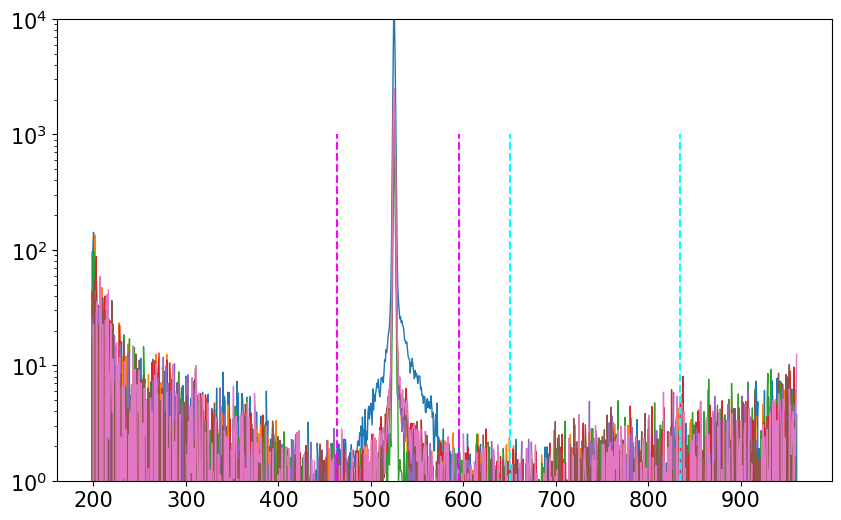

In [398]:
data_unsat = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22_0.5Sun.txt', delimiter = '\t', index_col = False)
del data_unsat[data_unsat.columns[-1]]
print(data_unsat)
emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data_unsat.values[emhigh,0]*np.ones(100) #input dashed lines to show boundaries
emlinelow = data_unsat.values[emlow,0]*np.ones(100)

exlinehigh = data_unsat.values[exhigh,0]*np.ones(100)
exlinelow = data_unsat.values[exlow,0]*np.ones(100)

emcts_low = np.zeros(7) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_low = np.zeros(7)


linebounds = np.linspace(1,1000,100)

fig = plt.figure(figsize = (10,6))
for K in range(7):
    plt.plot(data_unsat.values[:,0],data_unsat.values[:,K+1],'-',lw=1)
    emcts_low[K] = np.sum(data_unsat.values[emlow:emhigh,K+1])
    excts_low[K] = np.sum(data_unsat.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data_unsat.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data_unsat.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

for 1 Sun Cs22 HS

Emission cts = 2.706e+02, Excitation cts = 3.537e+04
Emission cts = 1.709e+02, Excitation cts = 6.420e+03
Emission cts = 2.384e+02, Excitation cts = 6.625e+03
Emission cts = 3.478e+02, Excitation cts = 6.555e+03
Emission cts = 1.071e+02, Excitation cts = 6.488e+03


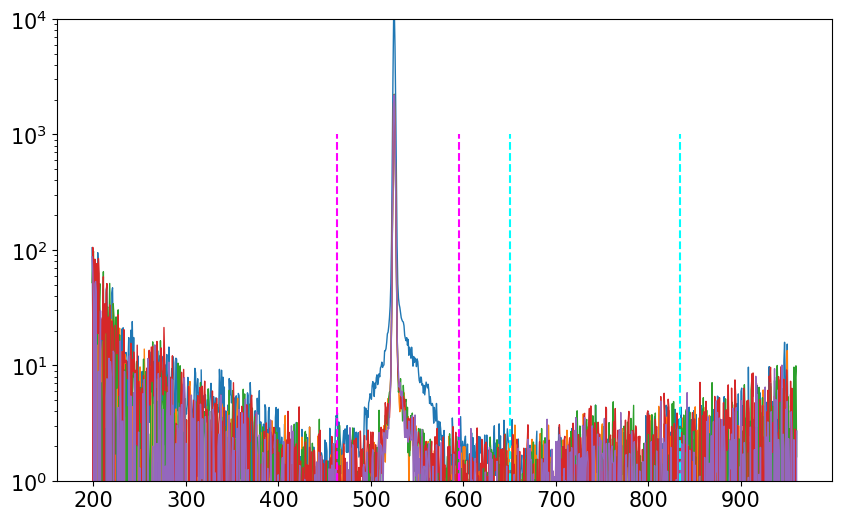

In [400]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [401]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[1],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(f'PLQY for Cs22 = {max(PLQYS)}') #prints highest PLQY obtained from measurments

PLQY for Cs22 = 0.14205589258523627


Now for HS Cs22+Imn

Emission cts = 1.258e+02, Excitation cts = 3.493e+04
Emission cts = 3.151e+02, Excitation cts = 5.957e+03
Emission cts = 6.457e+01, Excitation cts = 6.028e+03
Emission cts = 1.283e+02, Excitation cts = 5.593e+03
Emission cts = 5.783e+01, Excitation cts = 3.641e+03


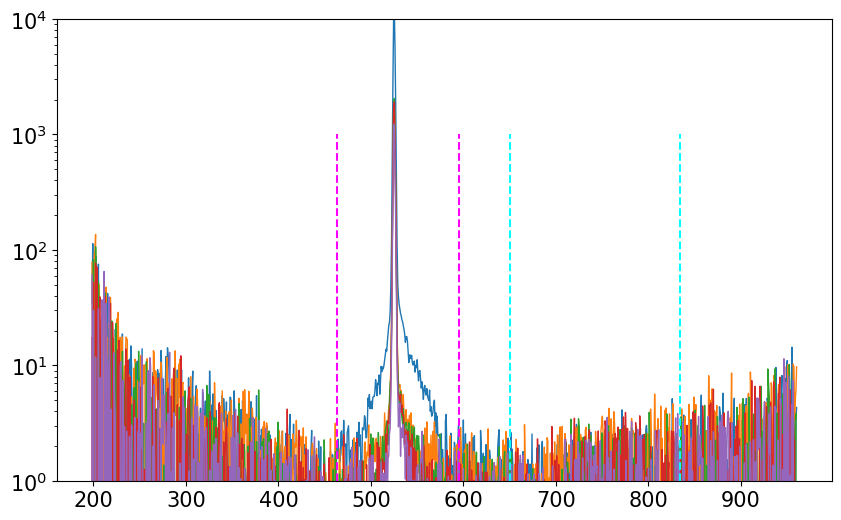

In [379]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [309]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[2],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(f'PLQY for HS Cs22 1%Imn = {max(PLQYS)}') #prints highest PLQY obtained from measurments

PLQY for HS Cs22 1%Imn = 0.3071552160165605


Emission cts = 5.889e+01, Excitation cts = 3.474e+04
Emission cts = 1.197e+02, Excitation cts = 6.155e+03
Emission cts = 1.044e+02, Excitation cts = 6.279e+03
Emission cts = 1.441e+02, Excitation cts = 6.525e+03
Emission cts = 8.652e+01, Excitation cts = 5.316e+03


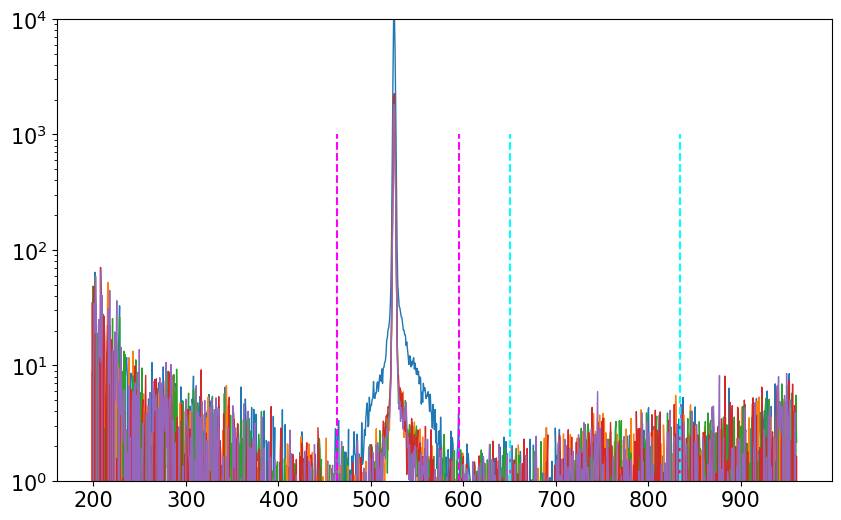

In [310]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525


emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [311]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[3],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print (PLQYS)
print(f'PLQY for HS Cs22 1%ImnBr = {max(PLQYS)}') #prints highest PLQY obtained from measurments

[0.11921584 0.08934068 0.16727202 0.0542173 ]
PLQY for HS Cs22 1%ImnBr = 0.1672720160654139


Emission cts = 6.557e+01, Excitation cts = 3.479e+04
Emission cts = 3.057e+02, Excitation cts = 1.561e+03
Emission cts = 4.015e+02, Excitation cts = 1.470e+03
Emission cts = 9.504e+01, Excitation cts = 1.412e+03
Emission cts = 7.622e+01, Excitation cts = 5.661e+03


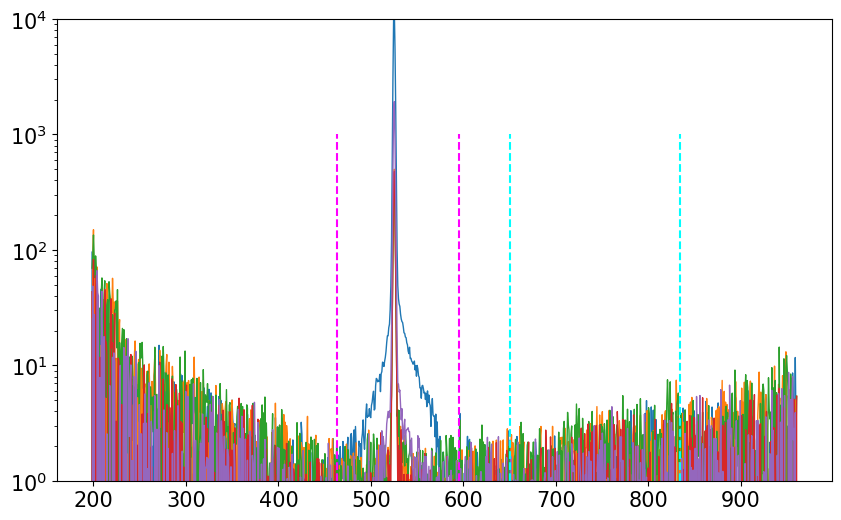

In [402]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22+Me4_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [406]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[4],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for HS Cs22+Me4 = {max(PLQYS)}') #prints highest PLQY obtained from measurments

[0.44811051 0.62692151 0.05500126 0.01988602]
PLQY for HS Cs22+Me4 = 0.6269215117068723


Emission cts = 6.524e+01, Excitation cts = 3.544e+04
Emission cts = 2.314e+02, Excitation cts = 4.450e+03
Emission cts = 1.269e+02, Excitation cts = 5.960e+03
Emission cts = 8.036e+01, Excitation cts = 6.715e+03
Emission cts = 2.432e+02, Excitation cts = 5.665e+03


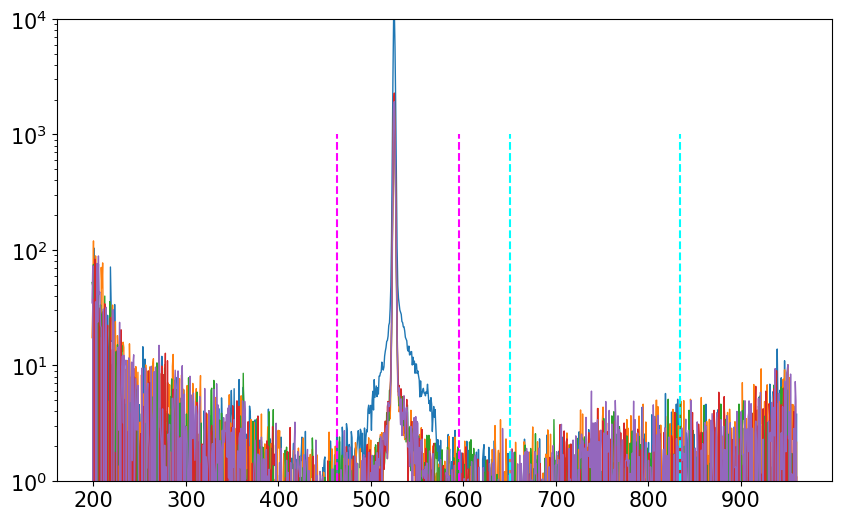

In [407]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22+Me4_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]


emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

emlinehigh = data.values[emhigh,0]*np.ones(100)
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100)

emcts_high = np.zeros(5)
excts_high = np.zeros(5)

fig = plt.figure(figsize = (10,6))
for K in range(5):
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #reads through each column
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) 
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [410]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[5],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for HS Cs22+Me4+1%Imn = {max(PLQYS)}') #prints highest PLQY obtained from measurments

[0.32352261 0.11999337 0.02944116 0.34666726]
PLQY for HS Cs22+Me4+1%Imn = 0.34666726084893773


Emission cts = 5.981e+01, Excitation cts = 3.598e+04
Emission cts = 9.463e+01, Excitation cts = 3.589e+03
Emission cts = 1.692e+02, Excitation cts = 2.933e+03
Emission cts = 2.593e+02, Excitation cts = 4.213e+03


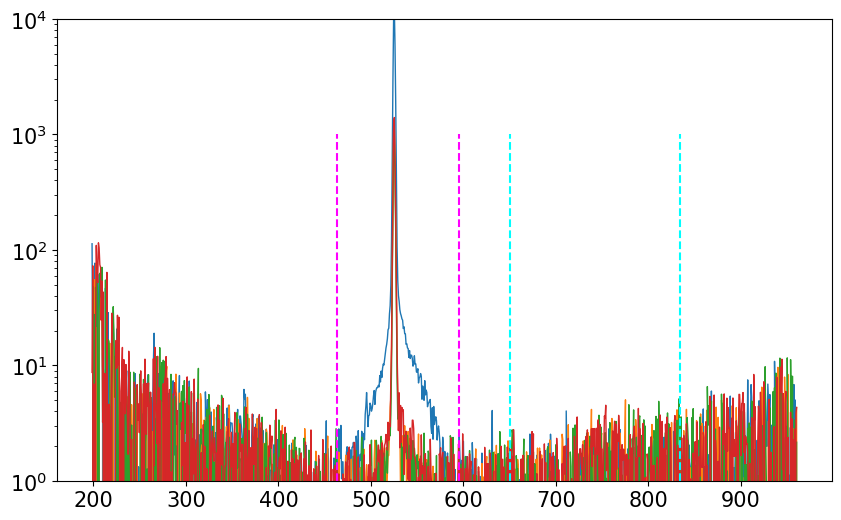

In [411]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/HS_Cs22+Me4_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

In [412]:
def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[6],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for HS Cs22+Me4+1%ImnBr = {max(PLQYS)}') #prints highest PLQY obtained from measurments

[0.06857209 0.21534149 0.39284749]
PLQY for HS Cs22+Me4+1%ImnBr = 0.392847494813022


# Here are the PLQYs for Cs22 on Halfstacks (HS)

## ITO/Me4/Al3O2/Cs22 = 0.14205589258523627
## ITO/Me4/Al3O2/Cs22 + 1%Imn = 0.3071552160165605
## ITO/Me4/Al3O2/Cs22 + 1%ImnBr = 0.1672720160654139
## HS Cs22+Me4 = 0.6269215117068723
## HS Cs22+Me4+1%Imn = 0.34666726084893773
## HS Cs22+Me4+1%ImnBr = 0.392847494813022

NOW I shall find the PLQYs on Device data 

      Wavelength          1       Cs22    Cs22+Imn  Cs22+ImnBr    Cs22+Me4  \
0     198.644331  34.830178 -17.415089  121.905624  -95.782991  174.150892   
1     199.407799 -32.425019  32.425019   32.425019  -56.743784  -32.425019   
2     200.171236  44.919146  59.892195  -59.892195  -97.324817   52.405671   
3     200.934641  75.986174 -48.354838   55.262672  -27.631336   75.986174   
4     201.698014   6.407267  -6.407267   32.036335  -19.221801   83.294471   
...          ...        ...        ...         ...         ...         ...   
1019  957.174282   1.707892  -2.277189   -0.000000   10.247350   -1.138594   
1020  957.896475  -6.745061  -1.124177    2.248354    1.686265   -1.124177   
1021  958.618618  -2.790144  10.044518    5.580288    0.558029   -3.348173   
1022  959.340711  -6.068207  -5.516552    0.551655   -1.654966   -5.516552   
1023  960.062755  -5.406984  -2.162794    7.569778   -9.732571   -1.081397   

      Cs22+Me4+Imn  Cs22+Me4+ImnBr  
0        69.660357       4

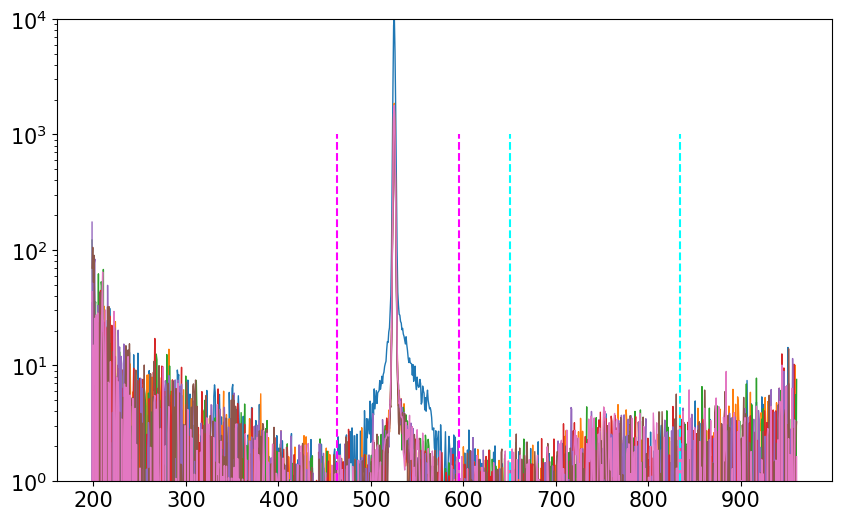

In [389]:
data_unsat = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Glass_Cs22_0.5Sun.txt', delimiter = '\t', index_col = False)
del data_unsat[data_unsat.columns[-1]]
print(data_unsat)
emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 7

emlinehigh = data_unsat.values[emhigh,0]*np.ones(100) #input dashed lines to show boundaries
emlinelow = data_unsat.values[emlow,0]*np.ones(100)

exlinehigh = data_unsat.values[exhigh,0]*np.ones(100)
exlinelow = data_unsat.values[exlow,0]*np.ones(100)

emcts_low = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_low = np.zeros(size)


linebounds = np.linspace(1,1000,100)

fig = plt.figure(figsize = (10,6))
for K in range(size):
    plt.plot(data_unsat.values[:,0],data_unsat.values[:,K+1],'-',lw=1)
    emcts_low[K] = np.sum(data_unsat.values[emlow:emhigh,K+1])
    excts_low[K] = np.sum(data_unsat.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data_unsat.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data_unsat.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

Emission cts = 3.582e+02, Excitation cts = 2.968e+04
Emission cts = 1.974e+02, Excitation cts = 1.224e+04
Emission cts = 1.700e+02, Excitation cts = 9.794e+03


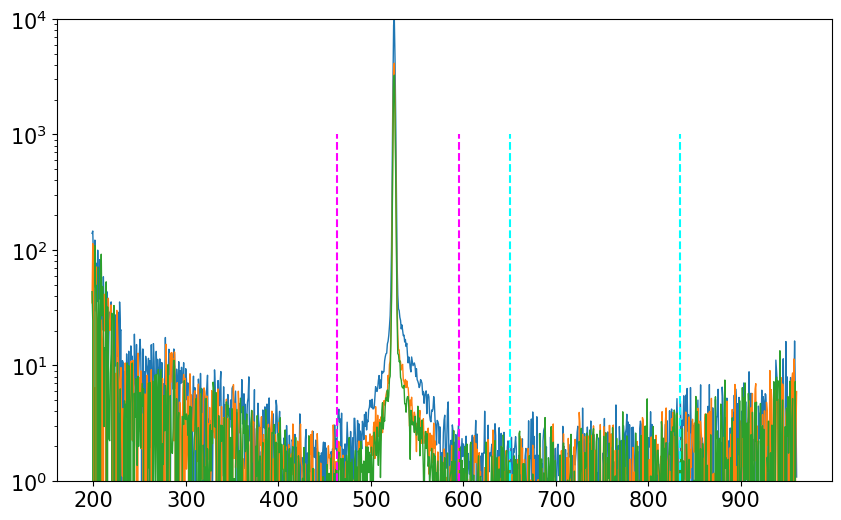

[-0.31475554 -0.36836061]
PLQY for Device Cs22 = -0.3147555436947243


In [390]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Device_Cs22_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 3 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[1],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22 = {max(PLQYS)}') #prints highest PLQY obtained from measurments


Emission cts = 4.045e+01, Excitation cts = 2.673e+04
Emission cts = 1.370e+02, Excitation cts = 4.808e+03
Emission cts = 1.028e+02, Excitation cts = 5.413e+03
Emission cts = 1.084e+02, Excitation cts = 5.205e+03


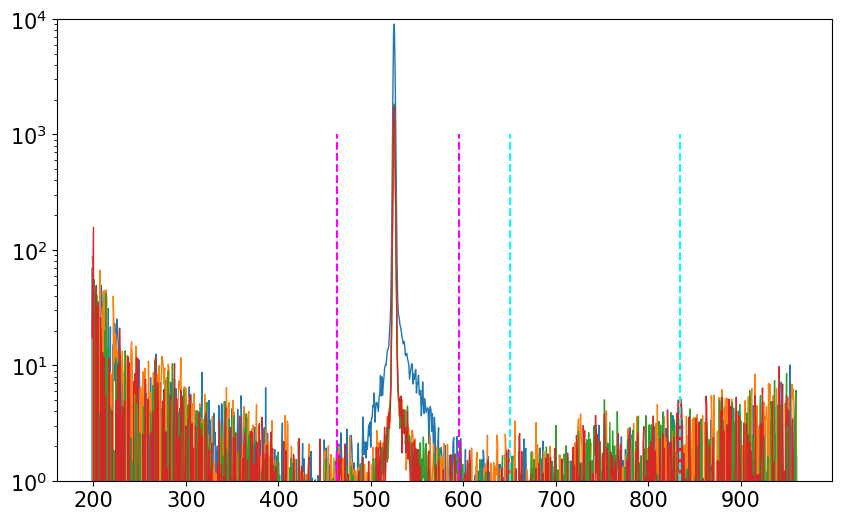

[0.18552989 0.11977487 0.13056599]
PLQY for Device Cs22+1%Imn = 0.1855298874939905


In [391]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Device_Cs22_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[2],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22+1%Imn = {max(PLQYS)}') #prints highest PLQY obtained from measurments


Emission cts = 2.503e+01, Excitation cts = 2.447e+04
Emission cts = 6.145e+01, Excitation cts = 6.244e+03
Emission cts = 6.274e+01, Excitation cts = 6.140e+03
Emission cts = 1.933e+02, Excitation cts = 5.809e+03


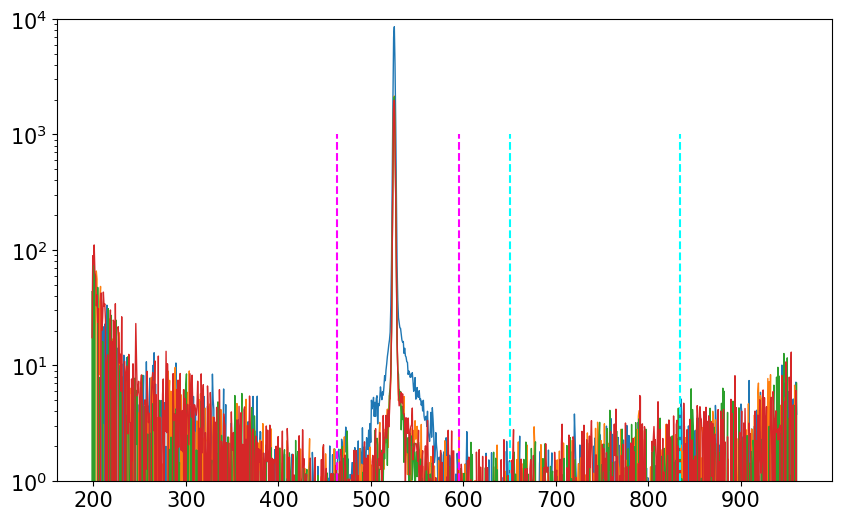

[0.07019755 0.07268407 0.32429123]
PLQY for Device Cs22+1%ImnBr = 0.3242912274761948


In [392]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Device_Cs22_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[3],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22+1%ImnBr = {max(PLQYS)}') #prints highest PLQY obtained from measurments


Emission cts = 4.780e+01, Excitation cts = 2.459e+04
Emission cts = 9.691e+01, Excitation cts = 4.080e+03
Emission cts = 5.739e+01, Excitation cts = 3.978e+03
Emission cts = 6.633e+01, Excitation cts = 4.677e+03
Emission cts = 1.939e+02, Excitation cts = 4.834e+03


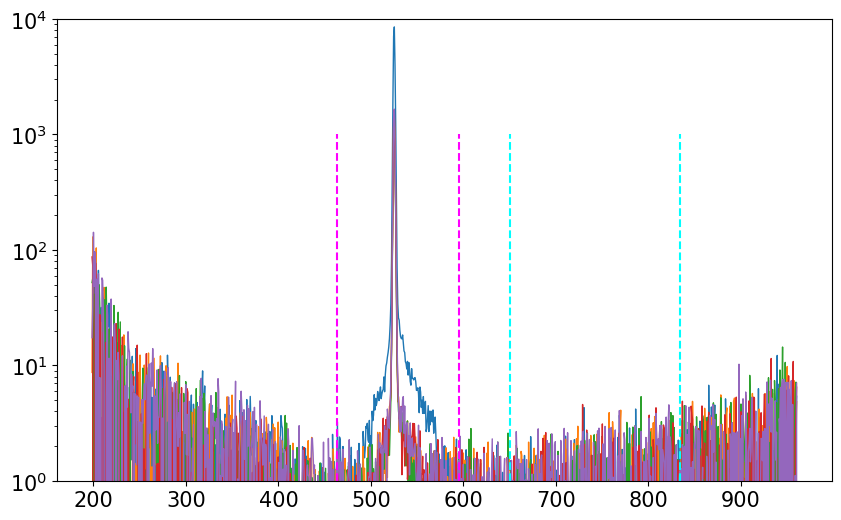

[0.09165102 0.01790201 0.0345808  0.27266133]
PLQY for Device Cs22+Me4 = 0.27266133100568085


In [413]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Devices_Cs22+Me4_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 5 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[4],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22+Me4 = {max(PLQYS)}') #prints highest PLQY obtained from measurments


Emission cts = 3.947e+01, Excitation cts = 2.803e+04
Emission cts = 3.241e+01, Excitation cts = 4.479e+03
Emission cts = 1.344e+02, Excitation cts = 8.130e+03
Emission cts = 5.567e+01, Excitation cts = 5.505e+03


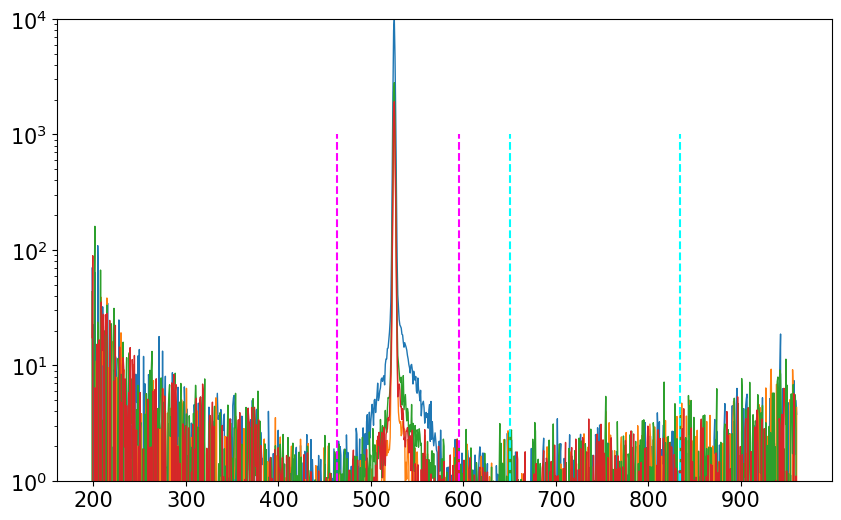

[-0.01327069  0.17836172  0.03043841]
PLQY for Device Cs22+Me4+1%Imn = 0.17836171729931233


In [393]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Device_Cs22+Me4_1%Imn_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[5],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22+Me4+1%Imn = {max(PLQYS)}') #prints highest PLQY obtained from measurments

Emission cts = 1.058e+02, Excitation cts = 2.380e+04
Emission cts = 1.879e+02, Excitation cts = 5.371e+03
Emission cts = 1.274e+02, Excitation cts = 5.151e+03
Emission cts = 2.110e+01, Excitation cts = 4.834e+03


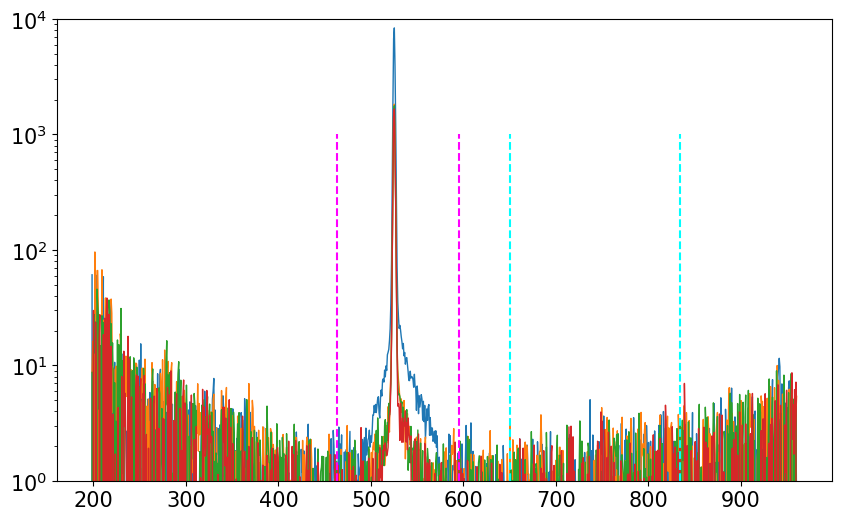

[ 0.15975123  0.0421066  -0.16477757]
PLQY for Device Cs22+Me4+1%ImnBr = 0.15975123156847232


In [394]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/06_22_2023_PLQY/Device_Cs22+Me4_1%ImnBr_1Sun.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[6],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Cs22+Me4+1%ImnBr = {max(PLQYS)}') #prints highest PLQY obtained from measurments

# PLQY for Devices - note that these devices did not come out well.. also there may be a difference depending on whether laser was hitting Ag or not?

## Cs22 = -0.3147555436947243
## Cs22+1%Imn = 0.1855298874939905
## Cs22+1%ImnBr = 0.3242912274761948
## Cs22+Me4 = 0.28148931085445256
## Cs22+Me4+1%Imn = 0.17836171729931233
## Cs22+Me4+1%ImnBr = 0.15975123156847232

07/06/23 Br25+HTL - HTLs include Me4, Cl-2, and Me4+Cl-2

      Wavelength          1           2          4           8
0     198.644331  43.537723  130.613169  69.660357  -87.075446
1     199.407799  40.531274  -40.531274  16.212510   56.743784
2     200.171236   7.486524  -22.459573 -14.973049   29.946098
3     200.934641  48.354838   55.262672  55.262672  117.433178
4     201.698014 -32.036335  -32.036335  57.665403  -38.443602
...          ...        ...         ...        ...         ...
1019  957.174282  -1.707892    0.000000  -0.569297   -1.138594
1020  957.896475   8.431326   -2.810442  -5.620884   10.679680
1021  958.618618   1.116058    1.116058  -6.138317   -3.906202
1022  959.340711   1.654966    6.619862  -1.103310   -3.309931
1023  960.062755  -3.244190   -0.540698  -4.325587   -2.162794

[1024 rows x 5 columns]
Emission cts = 2.135e+01, Excitation cts = 2.126e+04
Emission cts = 5.829e+01, Excitation cts = 3.102e+03
Emission cts = 5.054e+01, Excitation cts = 3.342e+03
Emission cts = 8.664e+01, Excitation cts = 3.149e+03


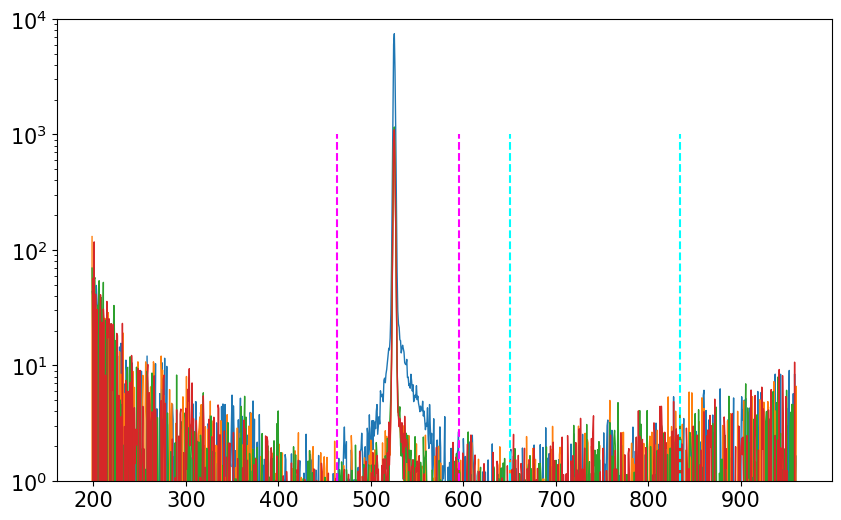

In [423]:
data_unsat = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/07_06_2023_PLQY/HS_Br25_+Me4_+Cl-2_Me4+Cl-2_0.5Sun.txt', delimiter = '\t', index_col = False)
del data_unsat[data_unsat.columns[-1]]
print(data_unsat)
emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4

emlinehigh = data_unsat.values[emhigh,0]*np.ones(100) #input dashed lines to show boundaries
emlinelow = data_unsat.values[emlow,0]*np.ones(100)

exlinehigh = data_unsat.values[exhigh,0]*np.ones(100)
exlinelow = data_unsat.values[exlow,0]*np.ones(100)

emcts_low = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_low = np.zeros(size)


linebounds = np.linspace(1,1000,100)

fig = plt.figure(figsize = (10,6))
for K in range(size):
    plt.plot(data_unsat.values[:,0],data_unsat.values[:,K+1],'-',lw=1)
    emcts_low[K] = np.sum(data_unsat.values[emlow:emhigh,K+1])
    excts_low[K] = np.sum(data_unsat.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data_unsat.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data_unsat.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

Emission cts = 1.149e+02, Excitation cts = 4.136e+04
Emission cts = 1.462e+02, Excitation cts = 6.768e+03
Emission cts = 9.183e+01, Excitation cts = 7.241e+03
Emission cts = 1.153e+02, Excitation cts = 7.179e+03


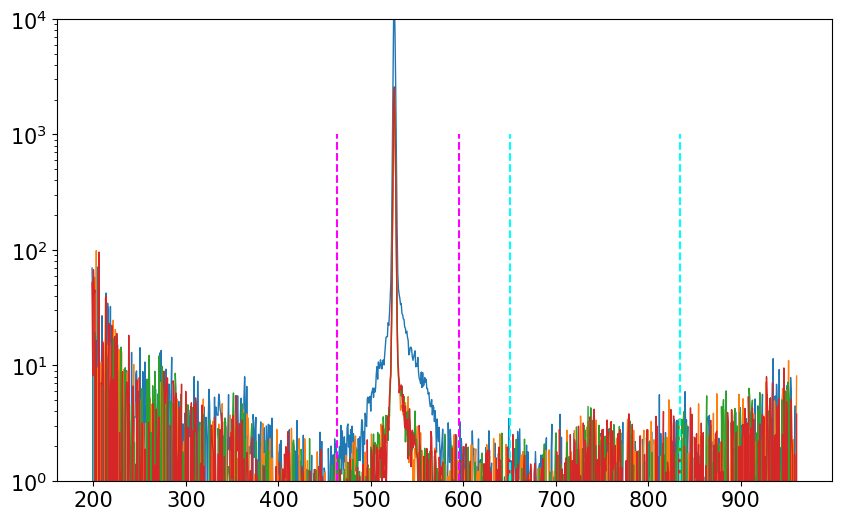

[ 0.08623666 -0.06359477  0.00106057]
PLQY for Device Br25+Me4 = 0.08623665731767807


In [440]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/07_06_2023_PLQY/HS_Br25_+Me4.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[1],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Br25+Me4 = {max(PLQYS)}') #prints highest PLQY obtained from measurments

Emission cts = 2.053e+02, Excitation cts = 4.303e+04
Emission cts = 8.895e+01, Excitation cts = 7.975e+03
Emission cts = 6.451e+01, Excitation cts = 7.762e+03
Emission cts = 1.111e+02, Excitation cts = 7.983e+03


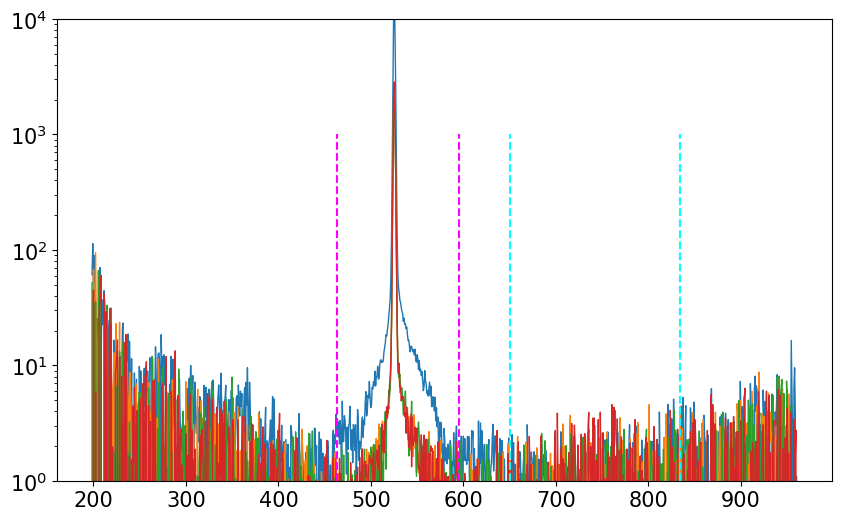

[-0.32461305 -0.39282621 -0.26284264]
PLQY for Device Br25+Cl-2 = -0.26284264068225216


In [435]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/07_06_2023_PLQY/HS_Br25_+Cl-2.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[2],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Br25+Cl-2 = {max(PLQYS)}') #prints highest PLQY obtained from measurments

Emission cts = 1.023e+02, Excitation cts = 4.474e+04
Emission cts = 1.462e+02, Excitation cts = 7.678e+03
Emission cts = 1.214e+02, Excitation cts = 7.284e+03
Emission cts = 7.685e+01, Excitation cts = 7.095e+03


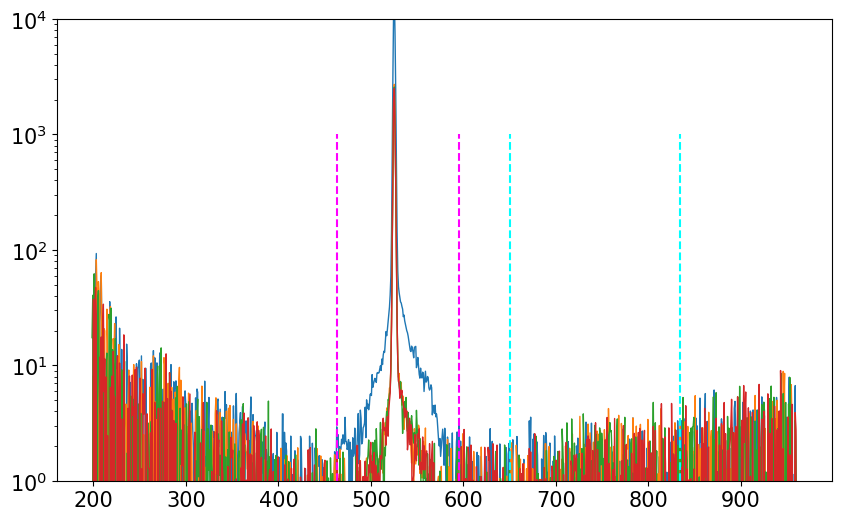

[ 0.12115739  0.05267146 -0.07028914]
PLQY for Device Br25+Me4:Cl-2 = 0.12115738664826826


In [438]:
data = pd.read_csv('/Users/julisajuarez/OneDrive - UW/PLQY Data/07_06_2023_PLQY/HS_Br25_+Me4+Cl-2.txt', delimiter = '\t', index_col = False)
del data[data.columns[-1]]

emlow = 600
emhigh = 850
exlow = 350
exhigh = 525

size = 4 #however many measurements taken per sample plus blank, does not include wavelength 

########### no changes necessary below ##########

emlinehigh = data.values[emhigh,0]*np.ones(100) #creates dashed lines for boundaries of integral/sum under curve
emlinelow = data.values[emlow,0]*np.ones(100)

exlinehigh = data.values[exhigh,0]*np.ones(100)
exlinelow = data.values[exlow,0]*np.ones(100)

linebounds = np.linspace(1,1000,100) #not sure actually

emcts_high = np.zeros(size) #creates matrix of 0s, this is the main difference between the 1 Sun and partial sun code
excts_high = np.zeros(size)

fig = plt.figure(figsize = (10,6)) #size of figure
for K in range(size): 
    plt.plot(data.values[:,0],data.values[:,K+1],'-',lw=1) #goes through each column and plots
    emcts_high[K] = np.sum(data.values[emlow:emhigh,K+1]) #sums the values within the boundaries
    excts_high[K] = np.sum(data.values[exlow:exhigh,K+1])
    print(f'Emission cts = {np.sum(data.values[emlow:emhigh,K+1]):.3e}, Excitation cts = {np.sum(data.values[exlow:exhigh,K+1]):.3e}')
    
plt.plot(emlinehigh,linebounds,'--',lw=1.5,color = 'cyan')
plt.plot(emlinelow,linebounds,'--',lw=1.5,color = 'cyan')

plt.plot(exlinehigh,linebounds,'--',lw=1.5,color = 'magenta')
plt.plot(exlinelow,linebounds,'--',lw=1.5,color = 'magenta')

plt.yscale('log')
plt.ylim(1,1e4)
plt.show()

def correctedPLQY(emctshigh_samp, emctshigh_glass, exctslow_samp, exctslow_glass, highsuns, lowsuns):
    ratio = highsuns/lowsuns
    emdiff = emctshigh_samp-emctshigh_glass
    exdiff = exctslow_glass-exctslow_samp
    return 100*emdiff/(exdiff*ratio)

PLQYS = (correctedPLQY(emcts_high[1:],emcts_high[0],excts_low[3],excts_low[0],1,0.5)) #this shows the PLQY for each of the measurements taken!!
print(PLQYS)
print(f'PLQY for Device Br25+Me4:Cl-2 = {max(PLQYS)}') #prints highest PLQY obtained from measurments